# Machine Learning

In [1]:
#Import necesseray packages
from scipy import stats
import itertools
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import roc_auc_score
#Ignore warnings
import warnings
warnings.filterwarnings("ignore")
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler
from statsmodels.formula.api import glm
import statsmodels.api as sm

In [4]:
#Import pandas adn read Breast Cancer CSV file
import pandas as pd

df=pd.read_csv('Desktop/Breast Cancer.csv')

In [5]:
best_cols=['radius_worst',
 'texture_worst',
 'perimeter_worst',
 'area_worst',
 'smoothness_worst',
 'compactness_worst',
 'concavity_mean',
 'concave points_mean',
 'symmetry_worst',
 'fractal_dimension_worst',
 'texture_se',
 'smoothness_se',
 'symmetry_se']

In [6]:
#create new DataFrame with the best_cols
dfnew=df[['diagnosis']].join(df[best_cols])

&nbsp;

To get our model to work, we first need to map the categorical values to integer values. Each integer value is represented as a binary vector; 0 and 1.In our case, we mapped Malignant cells with 1 and Benign cells with 0 and created new column with the assigned values.

We assign our X and y variables based on the dfnew – the modified df where we added a new column. We predict the y – Benign or Malignant– given the X features.

The training will be done on 55% of the data. The remaining 45% will be our hold-out set that will be left untouched until the final model has been selected and tuned.

Before using of different supervised machine learning approaches we performed hyperparameter tuning to find out what estimators works most effectively. The metric used is roc_auc for accuracy over 5-fold cross-validation. Also, we used the different thresholds in the models to get the best score and best thresholds.


### 1-Logistic Regression

In [21]:
# Build target variable
dfnew['M']=(dfnew['diagnosis']=='M')*1
y=dfnew['M']

#Build independent variables
x=dfnew.iloc[:,1:-1]

In [22]:
# Split data into Train and Test set
X_train,X_test,y_train,y_test=train_test_split(x,y,test_size=0.45,random_state=0)

In [23]:
# GridSearch to optimize paramater for Logistic Regression
param_grid={'C':np.arange(1,50)}
logreg=LogisticRegression()
logregcv=GridSearchCV(logreg,param_grid,cv=5,scoring='roc_auc')
logregcv.fit(X_train,y_train)
logregcv.best_params_

{'C': 31}

In [24]:
#Use Logistic Regression with the parameter of C=31
lrclasifier=LogisticRegression(C=31)
lrclasifier.fit(X_train,y_train)
y_prob=lrclasifier.predict_proba(X_test)[:,1]
y_pred=lrclasifier.predict(X_test)
fpr,tpr,thresholds=roc_curve(y_test,y_prob)

In [25]:
#find the best thresholds and best score looping over the thresholds that I found 
threshold=[]
betascore=[]
for thresh in np.unique(y_prob):
    y_thresh=y_prob>thresh
    threshold.append(thresh)
    betascore.append(fbeta_score(y_test,y_thresh,beta=0.5))

best threshold is: 0.6529148381619775
best score is: 0.9748427672955976


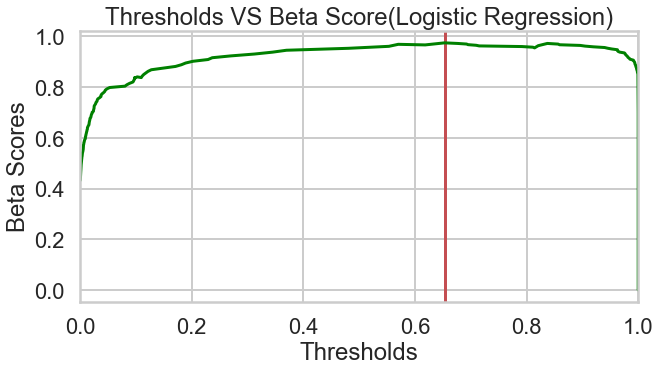

In [26]:
#Plotting the thresholds vs Beta Score
#Vertical line at optimal threshold
sns.set_style("whitegrid")
sns.set_context("poster")
plt.figure(figsize=(10,5))
plt.xlim(0,1)
plt.axvline(threshold[np.argmax(betascore)], color='r')
plt.plot(threshold, betascore,color='green')
plt.xlabel("Thresholds")
plt.ylabel("Beta Scores")
plt.title("Thresholds VS Beta Score(Logistic Regression)")
print('best threshold is:',threshold[np.argmax(betascore)])
print('best score is:',max(betascore))

Text(0.5, 1.0, 'Logistic Regression ROC Curve')

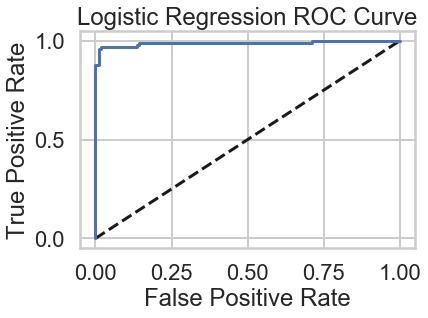

In [27]:
#Create ROC curve
plt.plot([0,1],[0,1],'k--')
plt.plot(fpr,tpr,label="Logistic Regression")
plt.ylabel("True Positive Rate")
plt.xlabel('False Positive Rate')
plt.title('Logistic Regression ROC Curve')

&nbsp;

### 2- KNeighborsClassifier 

In [28]:
## GridSearch to optimize paramater for KNeighbors Classifier
knnclasifier=KNeighborsClassifier()
param_grid={'n_neighbors':np.arange(1,50)}
knn_cv=GridSearchCV(knnclasifier,param_grid,cv=5,scoring='roc_auc')
knn_cv.fit(X_train,y_train)
knn_cv.best_params_

{'n_neighbors': 39}

In [29]:
#Use KNeighbors Classifier with the parameter of n_neighbors=39
knn=KNeighborsClassifier(n_neighbors=39)
knn.fit(X_train,y_train)
y_prob=knn.predict_proba(X_test)[:,1]
fpr,tpr,thresholds=roc_curve(y_test,y_prob)

In [30]:
#find the best thresholds and best score looping over the thresholds that I found 
thresholdknn=[]
betascoreknn=[]
for thresh in np.unique(y_prob):
    y_thresh=y_prob>thresh
    thresholdknn.append(thresh)
    betascoreknn.append(fbeta_score(y_test,y_thresh,beta=0.5))

best threshold is: 0.5384615384615384
best score is: 0.9410430839002267


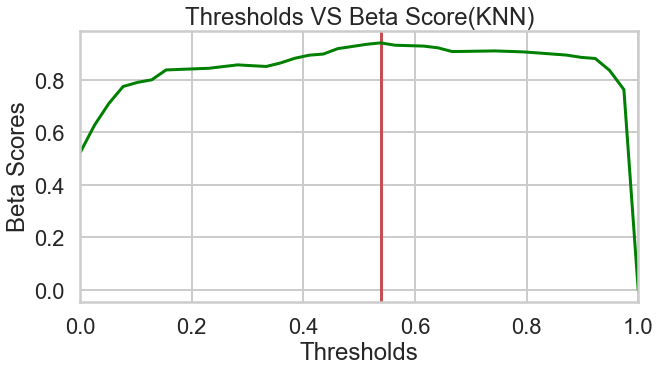

In [31]:
#Plotting the thresholds vs Beta Score
#Vertical line at optimal threshold
plt.figure(figsize=(10,5))
plt.xlim(0,1)
plt.axvline(thresholdknn[np.argmax(betascoreknn)], color='r')
plt.plot(thresholdknn, betascoreknn,color='green')
plt.xlabel("Thresholds")
plt.ylabel("Beta Scores")
plt.title("Thresholds VS Beta Score(KNN)")
print('best threshold is:',thresholdknn[np.argmax(betascoreknn)])
print('best score is:',max(betascoreknn))

F-beta score : 0.9271523178807949


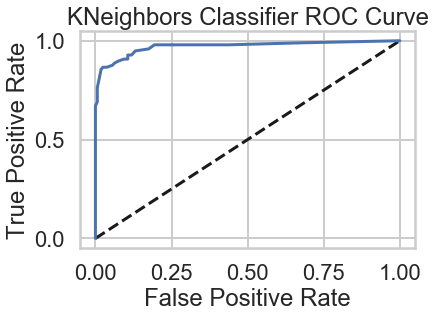

In [32]:
#Create ROC curve
plt.plot([0,1],[0,1],'k--')
plt.plot(fpr,tpr,label="KNeighbors Classifier")
plt.ylabel("True Positive Rate")
plt.xlabel('False Positive Rate')
plt.title('KNeighbors Classifier ROC Curve')
print('F-beta score :',fbeta_score(y_test,knn.predict(X_test),beta=0.5))

&nbsp;

### 3-Random Forest Classifier
```python
## GridSearch to optimize paramater for KNeighbors Classifier
rf=RandomForestClassifier( )
param_grid={'n_estimators':np.arange(90,120) ,'max_depth':np.arange(5,20),'max_features':np.arange(1,5)}
rf_cv=GridSearchCV(rf,param_grid,cv=5,scoring='roc_auc')
rf_cv.fit(X_train,y_train)
rf_cv.best_params_
```

In [33]:
#Use RandomForestClassifier with the best parameters 
rf=RandomForestClassifier(max_depth=19,max_features=4,n_estimators=118 )
rf.fit(X_train,y_train)
y_prob=rf.predict_proba(X_test)[:,1]
fpr,tpr,thresholds=roc_curve(y_test,y_prob)

In [34]:
roc_auc_score(y_test, rf.predict_proba(X_test)[:,1])

0.9863402061855671

In [35]:
#find the best thresholds and best score looping over the thresholds that I found 
thresholdrf=[]
betascorerf=[]
for thresh in thresholds:
    y_thresh=y_prob>thresh
    thresholdrf.append(thresh)
    betascorerf.append(fbeta_score(y_test,y_thresh,beta=0.5))

best threshold is: 0.652542372881356
best score is: 0.9673659673659672


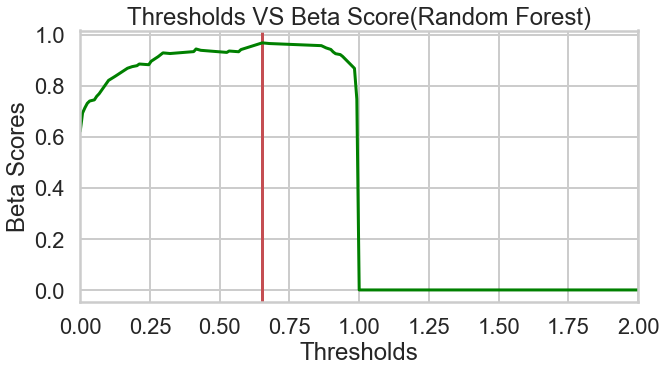

In [36]:
#Plotting the thresholds vs Beta Score
#Vertical line at optimal threshold
plt.figure(figsize=(10,5))
plt.xlim(0,2)
plt.axvline(thresholdrf[np.argmax(betascorerf)], color='r')
plt.plot(thresholdrf, betascorerf,color='green')
plt.xlabel("Thresholds")
plt.ylabel("Beta Scores")
plt.title("Thresholds VS Beta Score(Random Forest)")
print('best threshold is:',thresholdrf[np.argmax(betascorerf)])
print('best score is:',max(betascorerf))

F-beta score : 0.9381663113006395


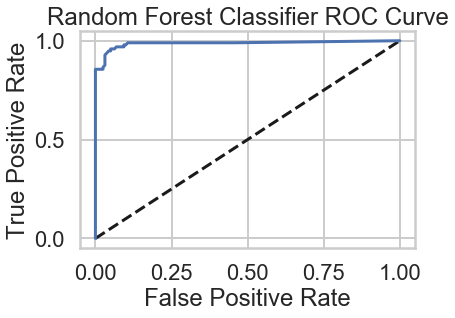

In [37]:
#Create ROC curve
plt.plot([0,1],[0,1],'k--')
plt.plot(fpr,tpr,label="Random Forest Classifier")
plt.ylabel("True Positive Rate")
plt.xlabel('False Positive Rate')
plt.title('Random Forest Classifier ROC Curve')
print('F-beta score :',fbeta_score(y_test,rf.predict(X_test),beta=0.5))

&nbsp;

### Detecting multicollinearity

In [41]:
#Created a new df to be able to standardize all features
X=dfnew.iloc[::,1:-1]

In [42]:
#Scaled all features
scaler = StandardScaler()
scaled_data = scaler.fit_transform(X)

In [43]:
#Converded list of arrays into df
scaled_df = pd.DataFrame(scaled_data ,columns=X.columns)

In [45]:
#Created a new df to calculate a Variance Inflation Factor scores
vif1 = pd.DataFrame()
vif1["variables"] = scaled_df.columns

In [47]:
vif1["VIF"] = [variance_inflation_factor(scaled_df.values, i) for i in range(scaled_df.shape[1])]

In [48]:
vif1

,variables,VIF
0,radius_worst,154.287634
1,texture_worst,2.389733
2,perimeter_worst,148.501728
3,area_worst,39.614820
4,smoothness_worst,3.429665
5,compactness_worst,9.557115
6,concavity_mean,11.482680
7,concave points_mean,17.139147
8,symmetry_worst,3.896686
9,fractal_dimension_worst,5.453913


```python 
As we can see on the VIF table above, radius_worst,perimeter_worst and area_worst have high variation inflation factor because they explain same variance.We will drop the two features that has the highest two variance.Also,concavity_mean and concave points_mean are higly correlated and they have high vif so we will drop the concave points_mean as well
```

In [50]:
#Dropped the features which has the highest variation inflation factor scores
scaled_df2=scaled_df.drop(['area_worst','perimeter_worst','concave points_mean'],axis=1)

In [51]:
vif2 = pd.DataFrame()
vif2["variables"] = scaled_df2.columns

In [53]:
vif2["VIF"] = [variance_inflation_factor(scaled_df2.values, i) for i in range(scaled_df2.shape[1])]

In [54]:
vif2

,variables,VIF
0,radius_worst,3.623543
1,texture_worst,2.251366
2,smoothness_worst,2.973325
3,compactness_worst,7.466057
4,concavity_mean,4.989982
5,symmetry_worst,3.858735
6,fractal_dimension_worst,4.961288
7,texture_se,2.614840
8,smoothness_se,2.553547
9,symmetry_se,3.402587


As we can see above, after dropping area_worst,perimeter_worst and concave points_mean features from the df, VIF scores are decreased

In [93]:
#Creating statmodels
all_features="+".join(scaled_df2.columns)
model_GLM = glm(formula = 'dfnew.M~'+all_features,data = scaled_df2, family = sm.families.Binomial()).fit() 

In [94]:
#Model Summary
model_GLM.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                dfnew.M   No. Observations:                  569
Model:                            GLM   Df Residuals:                      558
Model Family:                Binomial   Df Model:                           10
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                    nan
Date:                Tue, 28 Apr 2020   Deviance:                          nan
Time:                        08:31:55   Pearson chi2:                 1.13e+04
No. Iterations:                   100                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                  -0.5290      0.360     -1.470      0.141      -1.234       0.176
radius_worst                7.2044      1.247      5.779      0.000       4.761       9.648
texture_worst               1.7992      0.470      3.826      0.000       0.878       2.721
smoothness_worst            1.5390      0.612      2.513      0.012       0.339       2.739
compactness_worst          -0.9534      0.852     -1.120      0.263      -2.623       0.716
concavity_mean              2.4454      0.752      3.253      0.001       0.972       3.919
symmetry_worst              1.0986      0.722      1.521      0.128      -0.317       2.514
fractal_dimension_worst    -0.2440      0.790     -0.309      0.758      -1.793       1.305
texture_se                 -0.1599      0.543     -0.294      0.769      -1.225       0.905
smoothness_se               0.1426      0.635      0.225      0.822      -1.102       1.388
symmetry_se                -0.4523      0.769     -0.588      0.556      -1.959       1.054
===========================================================================================
"""